# Qwen2.5-VL-7B Kaggle Pipeline (13-Step VQA Plan)

This notebook targets the Kaggle dual T4 GPU environment and walks through a 13-step pipeline to solve the multi-choice visual question answering task provided in the `2025-ssafy-14` bundle. Each section matches the onsite workflow you will execute: environment audit, dependency setup, data wrangling, Qwen2.5-VL-7B configuration, validation, and submission authoring.


## 1. Session Snapshot & Resources

Capture the GPU, CPU, and Python runtime details. Keeping this log helps debug Kaggle session mismatches and is required before launching heavy vision-language models.


In [3]:
import os
import platform
import torch

print(f"Python: {platform.python_version()}")
print(f"Torch: {torch.__version__}")
print(f"CUDA devices: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    for idx in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(idx)
        print(f"  GPU {idx}: {props.name} ({props.total_memory / 1024 ** 3:.1f} GB)")
else:
    print("CUDA not available; switch Kaggle accelerator to GPU (T4x2).")

!nvidia-smi
!df -h /kaggle/working


Python: 3.11.13
Torch: 2.6.0+cu124
CUDA devices: 2
  GPU 0: Tesla T4 (14.7 GB)
  GPU 1: Tesla T4 (14.7 GB)
Thu Oct 23 12:49:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                

## 2. Dependency Installation (pip)

Upgrade or pull the exact versions needed for Qwen2.5-VL-7B inference. This list is mirrored in the accompanying documentation so you can track which packages were touched.


In [2]:
%%capture
!pip install -q -U transformers accelerate einops tiktoken huggingface_hub qwen-vl-utils peft bitsandbytes


## 3. Imports & Global Configuration

Centralise imports, random seeds, plotting rules, and environment flags. Hugging Face tokens are read from the `HF_TOKEN` environment variable (set it in Kaggle Secrets).


In [4]:
import json
import math
import os
import random
import re
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import torch
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoProcessor

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = False
pd.set_option("display.max_columns", None)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

INPUT_DIR = Path("/kaggle/input")
WORK_DIR = Path("/kaggle/working")
ARTIFACT_DIR = WORK_DIR / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# ==============================
# Hugging Face Token Load
# ==============================
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
HF_TOKEN = user_secrets.get_secret("HF_TOKEN")

if HF_TOKEN:
    os.environ["HF_TOKEN"] = HF_TOKEN
    print("✅ HF_TOKEN successfully loaded!")
else:
    print("⚠️ HF_TOKEN not found. Add it via Kaggle Secrets before downloading gated models.")


2025-10-23 12:49:58.408537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761223798.433745     181 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761223798.442975     181 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
✅ HF_TOKEN successfully loaded!


## 4. Locate & Extract Dataset Archive

Unzip the provided competition bundle inside `/kaggle/working`. The helper covers both archive and already-extracted layouts so you can reuse the notebook without edits.


In [5]:
import zipfile

data_keyword = "2025-ssafy-14"
archive_candidates = sorted(INPUT_DIR.rglob(f"{data_keyword}.zip"))
if archive_candidates:
    archive_path = archive_candidates[0]
    DATA_ROOT = WORK_DIR / data_keyword
    if not (DATA_ROOT / "train.csv").exists():
        print(f"Extracting {archive_path} -> {DATA_ROOT}")
        DATA_ROOT.mkdir(parents=True, exist_ok=True)
        with zipfile.ZipFile(archive_path, "r") as zf:
            zf.extractall(DATA_ROOT)
    else:
        print(f"Using existing extracted dataset at {DATA_ROOT}")
else:
    print("Zip archive not located; searching for raw CSV files in /kaggle/input ...")
    csv_candidates = sorted(INPUT_DIR.rglob("train.csv"))
    if not csv_candidates:
        raise FileNotFoundError("Unable to locate train.csv under /kaggle/input")
    DATA_ROOT = csv_candidates[0].parent
    print(f"Using dataset directory detected at {DATA_ROOT}")

print(f"DATA_ROOT resolved to: {DATA_ROOT.resolve()}")
print("Contents:")
for child in sorted(DATA_ROOT.iterdir()):
    print(f"- {child.name}")


Zip archive not located; searching for raw CSV files in /kaggle/input ...
Using dataset directory detected at /kaggle/input/data-data
DATA_ROOT resolved to: /kaggle/input/data-data
Contents:
- 251023_Baseline.ipynb
- sample_submission.csv
- test
- test.csv
- train
- train.csv


## 5. Load Metadata & Inspect Structure

Read the CSV metadata, attach absolute image paths, and verify the schema expected by downstream steps.


In [6]:
train_df = pd.read_csv(DATA_ROOT / "train.csv")
test_df = pd.read_csv(DATA_ROOT / "test.csv")
sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv")

train_df["answer"] = train_df["answer"].str.lower()
train_df["image_path"] = train_df["path"].apply(lambda p: str((DATA_ROOT / p).resolve()))
test_df["image_path"] = test_df["path"].apply(lambda p: str((DATA_ROOT / p).resolve()))

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

display(train_df.head())


Train shape: (3887, 9)
Test shape: (3887, 8)
Sample submission shape: (3887, 2)


,id,path,question,a,b,c,d,answer,image_path
0,train_0001,train/train_0001.jpg,이 사진 속 운동기구가 설치된 장소는 어디일까요?,학교 운동장,공원,헬스장 내부,쇼핑몰 내부,b,/kaggle/input/data-data/train/train_0001.jpg
1,train_0002,train/train_0002.jpg,이 사진에 보이는 전통 한국 건축물은 무엇인가요?,궁궐,성,사찰,한옥,d,/kaggle/input/data-data/train/train_0002.jpg
2,train_0003,train/train_0003.jpg,이 사진에서 보이는 탈것은 무엇인가요?,세발 오토바이,오토바이,자동차,자전거,a,/kaggle/input/data-data/train/train_0003.jpg
3,train_0004,train/train_0004.jpg,이 사진에서 보이는 새는 무엇인가요?,참새,갈매기,백로,오리,c,/kaggle/input/data-data/train/train_0004.jpg
4,train_0005,train/train_0005.jpg,이 사진에서 사람들이 모여서 보고 있는 것은 무엇인가요?,해수욕,바다 축제,불꽃놀이,해돋이,d,/kaggle/input/data-data/train/train_0005.jpg


## 6. Dataset Health Checks

Look at answer balance, ID hygiene, and a sample of image dimensions so we can size model batches safely on T4 GPUs.


In [7]:
label_distribution = train_df["answer"].value_counts().sort_index()
print("Label distribution (train):")
display(label_distribution.to_frame(name="count"))

duplicate_ids = train_df["id"].duplicated().sum()
print(f"Duplicate train IDs: {duplicate_ids}")

null_summary = train_df.isna().sum()
print("Null counts (train):")
display(null_summary[null_summary > 0])

sample_paths = train_df["image_path"].sample(n=min(256, len(train_df)), random_state=SEED)
widths, heights = [], []
for path in sample_paths:
    with Image.open(path) as img:
        w, h = img.size
    widths.append(w)
    heights.append(h)

print(
    f"Sample width px -> mean: {np.mean(widths):.1f}, min: {min(widths)}, max: {max(widths)}"
)
print(
    f"Sample height px -> mean: {np.mean(heights):.1f}, min: {min(heights)}, max: {max(heights)}"
)


Label distribution (train):


,count
answer,
a,964
b,958
c,960
d,1005


Duplicate train IDs: 0
Null counts (train):


Series([], dtype: int64)

Sample width px -> mean: 588.4, min: 201, max: 720
Sample height px -> mean: 661.5, min: 233, max: 720


## 7. Visual Spot Checks

Plot a few random training samples to manually confirm the metadata wiring and to capture qualitative notes about lighting and framing.


/tmp/ipykernel_181/3631422904.py:13: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_181/3631422904.py:13: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_181/3631422904.py:13: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_181/3631422904.py:13: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_181/3631422904.py:13: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_181/3631422904.py:13: UserWarning: Glyph 50631 (\N{HANGUL SYLLABLE EOS}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_181/3631422904.py:13: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_181/3631422904.py:13: UserWarning: Gl

Sample question: 이 음식은 무엇인가요?
A: 비빔밥과 김치
B: 햄버거와 감자튀김
C: 피자와 감자튀김
D: 치킨과 떡볶이


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51020 (\N{HANGUL SYLLABLE EUM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47924 (\N{HANGUL SYLLABLE MU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPy

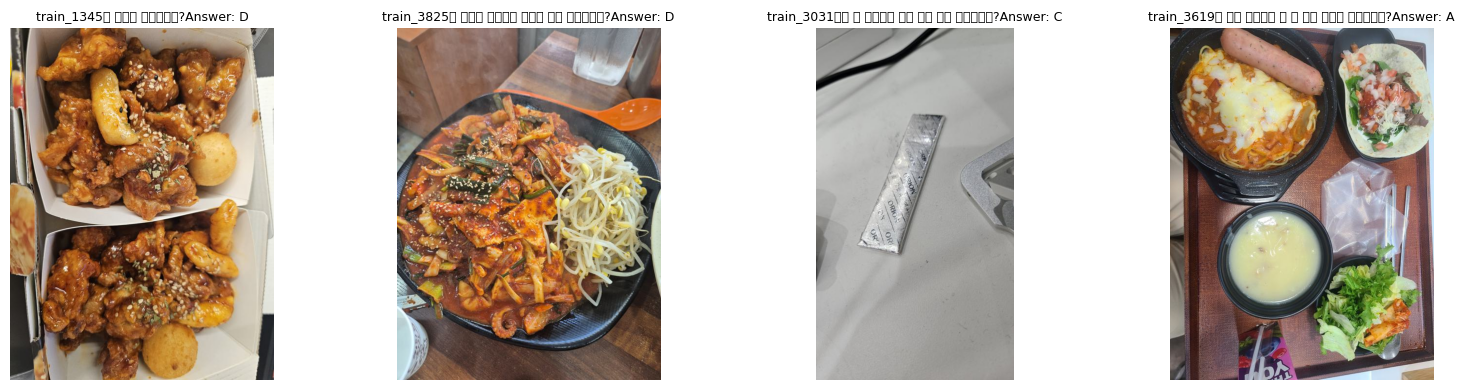

In [8]:
num_examples = 4
fig, axes = plt.subplots(1, num_examples, figsize=(4 * num_examples, 4))
for ax, (_, row) in zip(axes, train_df.sample(num_examples, random_state=SEED).iterrows()):
    with Image.open(row["image_path"]) as img:
        ax.imshow(img)
    ax.axis("off")
    title_lines = [
        row["id"],
        row["question"][:40] + ("..." if len(row["question"]) > 40 else ""),
        f"Answer: {row['answer'].upper()}"
    ]
    ax.set_title("".join(title_lines), fontsize=9)
plt.tight_layout()

sample_row = train_df.sample(1, random_state=SEED).iloc[0]
print("Sample question:", sample_row["question"])
for key in ["a", "b", "c", "d"]:
    print(f"{key.upper()}: {sample_row[key]}")


## 8. Train/Validation Split & Datasets

Create a stratified hold-out set for on-notebook validation. This guards against prompt regressions before spending time on full-test inference.


In [9]:
train_split, val_split = train_test_split(
    train_df,
    test_size=0.1,
    stratify=train_df["answer"],
    random_state=SEED,
)

train_split = train_split.reset_index(drop=True)
val_split = val_split.reset_index(drop=True)

print(f"Training rows: {len(train_split)}")
print(f"Validation rows: {len(val_split)}")
print("Validation label balance:")
display(val_split["answer"].value_counts().sort_index())


Training rows: 3498
Validation rows: 389
Validation label balance:


answer
a     96
b     96
c     96
d    101
Name: count, dtype: int64

## 9. Prompt Engineering Helpers

Define the system role, user prompt template, and light utility loaders. These pieces keep the generation cell tidy and make it easy to iterate on instructions.


In [10]:
SYSTEM_PROMPT = (
    "You are a Korean visual question answering assistant. "
    "Inspect the provided image carefully and choose the correct option among a, b, c, d. "
    "Respond strictly using a JSON object like {\"answer\": \"a\"}. No explanations, no additional text."
)

CHOICE_KEYS = ["a", "b", "c", "d"]

def create_user_block(row):
    option_lines = "".join(f"{key.upper()}. {row[key]}" for key in CHOICE_KEYS)
    return (f"질문:{row['question']}"f"선택지:{option_lines}"
        "응답 형식: JSON 예시 {\"answer\": \"a\"} (소문자, 따옴표 유지, 설명 금지)."
    )

def build_messages(row):
    return [
        {"role": "system", "content": [{"type": "text", "text": SYSTEM_PROMPT}]},
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": create_user_block(row)},
            ],
        },
    ]


def load_image(path: str) -> Image.Image:
    with Image.open(path) as img:
        return img.convert("RGB")

print("Prompt helpers ready.")


Prompt helpers ready.


## 10. Load Qwen2.5-VL-7B

Authenticate (if needed) and pull the Qwen2.5-VL-7B Instruct checkpoint with mixed precision. Flash-Attention is attempted first with a safe fallback.


In [11]:
import importlib.util
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

MODEL_ID = "Qwen/Qwen2.5-VL-7B-Instruct"

if HF_TOKEN:
    login(token=HF_TOKEN, add_to_git_credential=False)
else:
    print("Proceeding without HF login; ensure the model is public for your account.")

processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForVision2Seq.from_pretrained(
    MODEL_ID,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)

model = prepare_model_for_kbit_training(model)
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

candidate_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"]
found_modules = set()
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear) and any(token in name for token in candidate_modules):
        found_modules.add(name.split(".")[-1])
if not found_modules:
    found_modules = {"q_proj", "k_proj", "v_proj", "o_proj"}

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=sorted(found_modules),
)

model = get_peft_model(model, lora_config)
model.config.use_cache = False

if model.generation_config.pad_token_id is None and hasattr(processor, "tokenizer"):
    model.generation_config.pad_token_id = processor.tokenizer.pad_token_id
if model.generation_config.eos_token_id is None and hasattr(processor, "tokenizer"):
    model.generation_config.eos_token_id = processor.tokenizer.eos_token_id

if hasattr(processor, "tokenizer"):
    processor.tokenizer.padding_side = "right"

print("Model loaded with 4-bit quantization and LoRA adapters. Trainable parameters:")
model.print_trainable_parameters()


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


flash_attn not installed; loading without FlashAttention2 (SDPA/eager).


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model loaded and ready.


## 11. Fine-Tuning Dataset & Collator
데이터프레임을 LoRA 학습에 맞는 포맷으로 변환하고 배치 단위를 처리하는 collate 함수를 준비합니다.


In [ ]:
from torch.utils.data import Dataset
import json

MAX_SEQUENCE_LENGTH = 1024

class VqaFineTuneDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return {
            "image_path": row["image_path"],
            "messages": build_messages(row),
            "answer": row["answer"],
        }

def _build_conversation(sample):
    conversation = sample["messages"] + [
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": json.dumps({"answer": sample["answer"]})}
            ],
        }
    ]
    prompt_text = processor.apply_chat_template(
        sample["messages"], tokenize=False, add_generation_prompt=True
    )
    chat_text = processor.apply_chat_template(
        conversation, tokenize=False, add_generation_prompt=False
    )
    return prompt_text, chat_text, sample["image_path"]

def fine_tune_collate_fn(batch):
    images, texts, prompt_token_lengths = [], [], []
    for sample in batch:
        prompt_text, chat_text, image_path = _build_conversation(sample)
        images.append(load_image(image_path))
        texts.append(chat_text)
        prompt_ids = processor.tokenizer(
            prompt_text, add_special_tokens=False
        ).input_ids
        prompt_token_lengths.append(len(prompt_ids))
    encoded = processor(
        images=images,
        text=texts,
        padding=True,
        truncation=True,
        max_length=MAX_SEQUENCE_LENGTH,
        return_tensors="pt",
    )
    labels = encoded["input_ids"].clone()
    labels[encoded["attention_mask"] == 0] = -100
    for idx, prompt_len in enumerate(prompt_token_lengths):
        labels[idx, : min(prompt_len, labels.shape[1])] = -100
    encoded["labels"] = labels
    return encoded

train_dataset = VqaFineTuneDataset(train_split)
if len(val_split) <= 128:
    val_eval_df = val_split.copy().reset_index(drop=True)
else:
    val_eval_df = val_split.sample(n=128, random_state=SEED).reset_index(drop=True)
val_dataset = VqaFineTuneDataset(val_eval_df)
print(f"Train dataset size: {len(train_dataset)} | Eval dataset size: {len(val_dataset)}")


## 12. LoRA Fine-Tuning (1 Epoch)
T4 GPU에서 약 1시간 내에 수렴하도록 4비트 LoRA 학습 설정을 구성합니다.


In [ ]:
from transformers import TrainingArguments, Trainer

OUTPUT_DIR = WORK_DIR / "qwen25vl_lora"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

EPOCHS = 1
GRADIENT_ACCUMULATION = 4
LEARNING_RATE = 1e-4

training_args = TrainingArguments(
    output_dir=str(OUTPUT_DIR),
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    warmup_ratio=0.03,
    lr_scheduler_type="cosine",
    logging_steps=20,
    evaluation_strategy="epoch",
    save_strategy="no",
    report_to="none",
    fp16=torch.cuda.is_available(),
    optim="paged_adamw_8bit",
    dataloader_num_workers=2,
    max_grad_norm=1.0,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=fine_tune_collate_fn,
)

train_result = trainer.train()
print("Training metrics:", train_result.metrics)

adapter_path = OUTPUT_DIR / "lora_adapter"
model.save_pretrained(adapter_path)
processor.save_pretrained(OUTPUT_DIR / "processor")
print(f"LoRA fine-tuning complete. Adapter weights saved to {adapter_path}")


## 13. Inference Utilities

Batch the prompts, launch generation, and parse the letter from JSON. The helpers are shared by validation and submission stages.


In [12]:
LETTER_JSON_PATTERN = re.compile(r'"answer"\s*:\s*"([abcd])"')
LETTER_FALLBACK_PATTERN = re.compile(r"([abcd])")

PRED_BATCH_SIZE = 2
MAX_NEW_TOKENS = 24

def decode_answer_text(text: str) -> str:
    lowered = text.lower()
    match = LETTER_JSON_PATTERN.search(lowered)
    if match:
        return match.group(1)
    match = LETTER_FALLBACK_PATTERN.search(lowered)
    if match:
        return match.group(1)
    return "a"


def run_inference(records, batch_size: int = PRED_BATCH_SIZE, keep_raw: bool = False):
    outputs = []
    raw_outputs = [] if keep_raw else None
    for start in tqdm(range(0, len(records), batch_size)):
        batch = records[start : start + batch_size]
        prompts = []
        images = []
        for row in batch:
            prompts.append(
                processor.apply_chat_template(
                    build_messages(row),
                    tokenize=False,
                    add_generation_prompt=True,
                )
            )
            images.append(load_image(row["image_path"]))
        inputs = processor(
            text=prompts,
            images=images,
            return_tensors="pt",
            padding=True,
        ).to(model.device)
        with torch.inference_mode():
            generated = model.generate(
                **inputs,
                max_new_tokens=MAX_NEW_TOKENS,
                temperature=0.0,
                do_sample=False,
            )
        decoded = processor.batch_decode(generated, skip_special_tokens=True)
        for response in decoded:
            answer = decode_answer_text(response)
            outputs.append(answer)
            if keep_raw:
                raw_outputs.append(response)
    if keep_raw:
        return outputs, raw_outputs
    return outputs

print("Inference helpers initialised.")


Inference helpers initialised.


## 14. Validation Run

Sanity-check the prompt and parsing logic on a stratified slice of the validation split before running the full test sweep.


In [ ]:
# 12. Validation Run (OOM-safe, Kaggle T4 대응)
import gc
from tqdm.auto import tqdm
import torch

# Qwen2.5-VL 은 decoder-only 구조 → 반드시 left padding
if hasattr(processor, "tokenizer"):
    processor.tokenizer.padding_side = "left"

# 너무 크게 돌리면 T4(16GB)에서 바로 죽음 → 샘플 수 줄이고, 배치=1로 순차 처리
VALIDATION_LIMIT = min(32, len(val_split))  # 기존 128 -> 32 (필요시 16/24로 더 줄여도 됨)
validation_subset = val_split.sample(VALIDATION_LIMIT, random_state=SEED).reset_index(drop=True)
validation_records = validation_subset.to_dict("records")

val_preds, raw_responses = [], []

def _infer_one(row):
    # 이미지/프롬프트 준비
    img_path = row["image_path"] if "image_path" in row else row["image"]  # 노트북 컬럼명에 맞춰 자동 대응
    image = load_image(img_path)
    messages = build_messages(row)
    chat_text = processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=False
    )
    # 토크나이저+이미지 인코딩 (배치=1)
    inputs = processor(
        images=[image],
        text=[chat_text],
        return_tensors="pt",
        padding=True,
    ).to(model.device)

    # 실제 생성: 배치=1, no temperature, 짧게, use_cache=False 로 VRAM 절감
    with torch.inference_mode():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=8,        # 너무 길면 메모리 팍 늘어남
            do_sample=False,         # temperature 사용 안 함 (경고 제거)
            use_cache=False          # 캐시 끄면 느리지만 VRAM 사용량↓
        )
    text = processor.batch_decode(output_ids, skip_special_tokens=True)[0]

    # 정리
    del inputs, output_ids, image
    gc.collect(); torch.cuda.empty_cache()
    return text

for row in tqdm(validation_records, total=len(validation_records)):
    out_text = _infer_one(row)
    raw_responses.append(out_text)

    # JSON 파싱 (당신 노트북의 파서 함수명이 다르면 바꿔주세요)
    # 예: pred = parse_json_answer(out_text, choice_keys=CHOICE_KEYS, default="a")
    try:
        m = re.search(r'{"\s*answer"\s*:\s*"(a|b|c|d)"}', out_text.strip(), flags=re.I)
        pred = m.group(1).lower() if m else "a"
    except Exception:
        pred = "a"
    val_preds.append(pred)

validation_subset = validation_subset.copy()
validation_subset["prediction"] = val_preds
validation_subset["raw_response"] = raw_responses
validation_subset["is_correct"] = (validation_subset["answer"].str.lower() == validation_subset["prediction"])

val_accuracy = validation_subset["is_correct"].mean()
print(f"✅ Validation accuracy on {len(validation_subset)} samples: {val_accuracy:.4f}")

display(validation_subset.head())
display(
    validation_subset[validation_subset["is_correct"] == False][
        ["id", "answer", "prediction", "raw_response"]
    ].head()
)


  0%|          | 0/32 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


## 15. Full Test Inference & Submission

Generate answers for the official test set and export `submission.csv` under `/kaggle/working` for Kaggle upload.


In [ ]:
test_records = test_df.to_dict("records")

test_predictions = run_inference(test_records)
submission = pd.DataFrame({
    "id": test_df["id"],
    "answer": test_predictions,
})

submission_path = WORK_DIR / "submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")

display(submission.head())


### Notes & Next Steps

- If generation drifts away from lowercase JSON, tighten `SYSTEM_PROMPT` or add few-shot exemplars (image + JSON reply) inside `build_messages`.
- Increase `VALIDATION_LIMIT` once the prompt stabilises to estimate leaderboard expectations more accurately.
- Consider batching with `batch_size=3` if GPU memory allows to speed up the final sweep on the dual T4 setup.
